<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/DAT264x_Identifying_Appliances_from_Energy_Use_Spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from numpy import array
import keras
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from tqdm import tqdm_notebook as tqdm
import os
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau
from sklearn.metrics import confusion_matrix

# Load data

In [3]:
train_images = []
train_idxs = []
train_labels = []
train_data_path = '/content/drive/My Drive/DAT264x/train'

for file_name in tqdm(os.listdir(train_data_path)):
  train_images.append(image.load_img(train_data_path+'/'+file_name))
  train_idxs.append(file_name.split('_')[0])

train = pd.DataFrame(index=train_idxs)
train.index.name = 'id'
train.index = train.index.astype('int64')
train['img'] = train_images
train.head()

,img
id,
1307,<PIL.Image.Image image mode=RGB size=176x128 a...
1385,<PIL.Image.Image image mode=RGB size=176x128 a...
1503,<PIL.Image.Image image mode=RGB size=176x128 a...
1519,<PIL.Image.Image image mode=RGB size=176x128 a...
1489,<PIL.Image.Image image mode=RGB size=176x128 a...


In [4]:
labels_path = '/content/drive/My Drive/DAT264x/train_labels.csv'
train_labels = pd.read_csv(labels_path,index_col=0)
train_labels.head()

,appliance
id,
1000,4
1001,9
1002,4
1003,9
1004,6


# merge

In [5]:
train = train.join(train_labels)
train.head()

,img,appliance
id,,
1000,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1000,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1001,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1001,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1002,<PIL.Image.Image image mode=RGB size=176x128 a...,4


In [6]:
train_1 = train[::2] #0 ~ end step2
train_2 = train[1::2]#1 ~ end step2 
train = train_1
train['img2'] = train_2['img']
train = train[['img','img2','appliance']]
train.head()

,img,img2,appliance
id,,,
1000,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1001,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1002,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1003,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1004,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,6


# set X_train

In [40]:
X_train = train[['img','img2']]
X_train.head()

,img,img2
id,,
1000,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1001,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1002,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1003,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1004,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...


# set Y_train

In [41]:
Y_train = train["appliance"]
Y_train.head()

id
1000    4
1001    9
1002    4
1003    9
1004    6
Name: appliance, dtype: int64

# count class

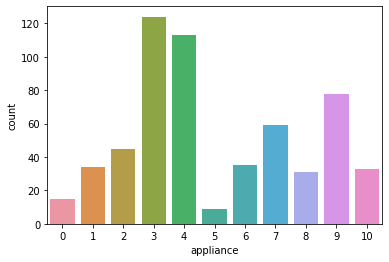

In [42]:
sns.countplot(Y_train)

# to numpy

In [43]:
img_data_list = []
img_data_list2 = []

for img,img2 in zip(X_train['img'],X_train['img2']):
    x1 = img_to_array(img)  # this is a Numpy array with shape (128,176,3)
    x1 = x1.reshape((1,) + x1.shape)  # this is a Numpy array with shape (1,128,176,3)
    x2 = img_to_array(img2)  # this is a Numpy array with shape (128,176,3)
    x2 = x2.reshape((1,) + x2.shape)  # this is a Numpy array with shape (1,128,176,3)
    img_data_list.append(x1)
    img_data_list2.append(x2)
print('total:',len(img_data_list))    
print('one of shape:',img_data_list[0].shape)

total: 576
one of shape: (1, 128, 176, 3)


# reshape and to_categorical

In [52]:
X1 = np.array(img_data_list).astype('float32').reshape(-1, 128, 176, 3)
X2 = np.array(img_data_list2).astype('float32').reshape(-1, 128, 176, 3)
X = X1 + X2
Y = np_utils.to_categorical(Y_train,num_classes = 11)
print('X.shape',X.shape)
print('Y.shape',Y.shape)

X.shape (576, 128, 176, 3)
Y.shape (576, 11)


# split

In [53]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2,random_state = 42)
X_train = X_train / 255.0
X_valid = X_valid / 255.0
print('X_train.shape',X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_valid.shape',X_valid.shape)
print('Y_valid.shape',Y_valid.shape)

X_train.shape (460, 128, 176, 3)
Y_train.shape (460, 11)
X_valid.shape (116, 128, 176, 3)
Y_valid.shape (116, 11)


# check data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


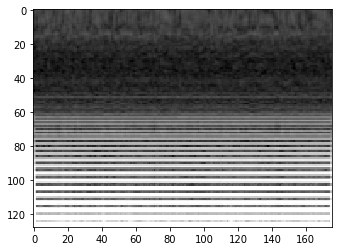

In [54]:
plt.imshow(X_train[0][:,:,:])

In [30]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(11,11), padding='same', activation='relu',input_shape=(128,176,3)))
model.add(Conv2D(filters=32, kernel_size=(11,11), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(11, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 176, 32)      11648     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 176, 32)      123936    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 35, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 33, 32)        9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 24288)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

In [0]:
model.compile(optimizer = "adam", 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

In [0]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0, 
                   patience = 10,  
                   mode = 'min',
                   restore_best_weights = True)

In [33]:
history = model.fit(X_train,Y_train,
                    batch_size = len(X_train),
                    epochs = 100,
                    validation_data = (X_valid,Y_valid),
                    verbose = 1,
                    callbacks = [es])

Train on 460 samples, validate on 116 samples
Epoch 1/100
460/460 [==============================] - 25s 54ms/step - loss: 2.6451 - acc: 0.1739 - val_loss: 2.3628 - val_acc: 0.1293
Epoch 2/100
460/460 [==============================] - 3s 7ms/step - loss: 2.3006 - acc: 0.1435 - val_loss: 2.3146 - val_acc: 0.2155
Epoch 3/100
460/460 [==============================] - 3s 7ms/step - loss: 2.2786 - acc: 0.2522 - val_loss: 2.1134 - val_acc: 0.2672
Epoch 4/100
460/460 [==============================] - 3s 7ms/step - loss: 2.1099 - acc: 0.2783 - val_loss: 2.0974 - val_acc: 0.3707
Epoch 5/100
460/460 [==============================] - 3s 7ms/step - loss: 2.0465 - acc: 0.3217 - val_loss: 1.9688 - val_acc: 0.4310
Epoch 6/100
460/460 [==============================] - 3s 7ms/step - loss: 1.9267 - acc: 0.3761 - val_loss: 1.8944 - val_acc: 0.3966
Epoch 7/100
460/460 [==============================] - 3s 7ms/step - loss: 1.8938 - acc: 0.3696 - val_loss: 1.8289 - val_acc: 0.4310
Epoch 8/100
460/460 [

# history

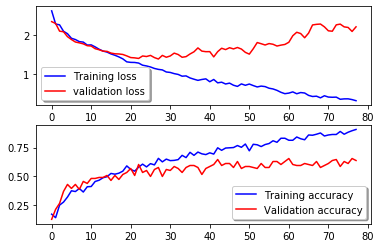

In [34]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# confusion_mtx

In [35]:
Y_pred = model.predict(X_valid) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_valid,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
pd.DataFrame(confusion_mtx).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9,10
0,1,0,0,1,0,1,0,0,0,0,1
1,0,1,0,0,1,1,0,0,0,1,0
2,0,1,3,3,0,0,0,0,0,0,0
3,0,0,0,26,4,0,0,0,0,1,0
4,0,0,0,1,22,0,0,1,0,2,0
5,0,0,0,0,1,0,0,0,0,2,0
6,0,1,0,2,1,0,1,0,0,1,0
7,0,0,0,3,0,0,0,2,0,0,0
8,0,0,0,2,1,0,0,0,5,0,0
9,0,0,0,7,2,0,0,1,0,5,0


# Display some error results 

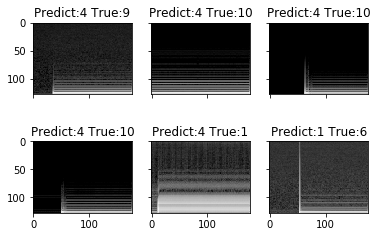

In [36]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((128,176,3)))
            ax[row,col].set_title("Predict:{} True:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)